# Entrenamiento de un modelo prediseñado con el dataset CIFAR-10

En esta práctica tenéis que probar vuestras propias funciones de inicialización de pesos y de planificador de tasa de entrenamiento.

https://pytorch.org/docs/stable/nn.init

https://pytorch.org/docs/stable/optim#how-to-adjust-learning-rate

In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import math

## Conjuntos de datos

Files already downloaded and verified
Dimensiones de las imagenes - altura: 32, anchura: 32, canales: 3
Files already downloaded and verified
Files already downloaded and verified


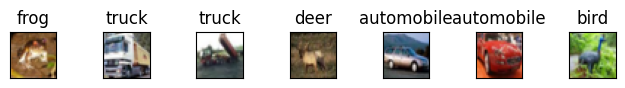

In [2]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
fig = plt.figure()
label_names = train_set.classes
for i, (data, label) in enumerate(train_set):
  data = data.permute(1, 2, 0)
  h, w, c = data.shape
  if i == 0:
    print(f"Dimensiones de las imagenes - altura: {h}, anchura: {w}, canales: {c}")
  plt.subplot(1,7,i+1)
  fig.tight_layout()
  plt.title(label_names[label])
  plt.imshow(data)
  plt.xticks([])
  plt.yticks([])
  if i > 5:
    break
      
# Normalizar
train_set = torch.stack([img for img, _ in train_set], dim=0)
mean = train_set.mean()
std = train_set.std()

batch_size = 16 # Tamaño de los lotes de muestras
# Preprocesado de las muestras
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=mean, std=std)
                                           ])

# Carga el dataset de entrenamiento y validación ya normalizado
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

## Modelo

In [3]:
class LeNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 kernel_size, stride, padding):
        super(LeNetBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 
                               kernel_size=kernel_size, stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.activacion = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)      

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.activacion(x)
        x = self.pool(x)
        return x
    
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Extracción de características
        self.block1 = LeNetBlock(in_channels=3, out_channels=6, 
                                 kernel_size=5, stride=1, padding=2)
        self.block2 = LeNetBlock(in_channels=6, out_channels=16, 
                                 kernel_size=5, stride=1, padding=0)

        # Clasificador
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.batchnorm1 = nn.BatchNorm1d(120)
        self.activacion1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 84)
        self.batchnorm2 = nn.BatchNorm1d(84)
        self.activacion2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Extracción de características
        x = self.block1(x)
        x = self.block2(x)
    
        # Flatten the tensor for fully connected layers
        x = x.view(-1, 16 * 6 * 6)

        # Clasificador
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = self.activacion1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = self.activacion2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [4]:
model = LeNet()

#### Nuestra nueva función de inicialización de pesos

In [5]:
# Definimos una nueva función para inicializar los pesos
def funcion_de_inicializacion(module):
    if isinstance(module, nn.Linear):
        with torch.no_grad():
            out_shape, in_shape = module.weight.shape
            # pesos = random[0,1] * 0.1 + 0.5
            module.weight.copy_(torch.randn_like(module.weight) * 0.1 + 0.5)
            if module.bias is not None:
                # bias = 0.2
                module.bias.fill_(0.2)
    elif isinstance(module, nn.Conv2d):
        with torch.no_grad():
            out_shape, in_shape, w, h = module.weight.shape
            # pesos = sin(random[0,1])
            module.weight.copy_(torch.sin(torch.randn_like(module.weight)))
            if module.bias is not None:
                # pesos = uniforme entre -0.1 y 0.1
                module.bias.uniform_(-0.1, 0.1)

# Inicializamos los pesos con nuestra función
model.apply(funcion_de_inicializacion);

#### Nuestro planificador de tasa de aprendizaje

In [6]:
# Implementamos nuestro propio planificador de tasa de aprendizaje
def learning_rate_scheduler(epoch, n_epochs, lr_inicial, lr_min):
    new_lr = epoch * (lr_inicial - lr_min) / n_epochs
    return new_lr

In [7]:
n_epochs = 5
lr_inicial = 0.1
lr_min = 0.0001

criterion = nn.CrossEntropyLoss()  # Función de pérdida
optimizer = optim.SGD(model.parameters(), lr=lr_inicial, weight_decay=0.001)

# Almacenamos métricas
train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

print("Empezamos el entrenamiento...")
for epoch in range(n_epochs): 
    # Métricas
    running_loss, correctas, total = 0.0, 0, 0

    # Actualizamos el learning rate
    new_lr = learning_rate_scheduler(epoch, n_epochs, lr_inicial, lr_min)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr
    
    model.train()
    for data, target in train_loader:        
        optimizer.zero_grad() # Reinicia el optimizador
        output = model(data) # Forward-Pass
        loss = criterion(output, target)
        loss.backward() # Backward-Pass
        optimizer.step() # Actualiza los pesos

        # Métricas
        running_loss += loss.item()
        _, prediccion = output.max(1)
        total += target.size(0)
        correctas += prediccion.eq(target).sum().item()
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correctas / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validación del modelo
    # Métricas
    val_loss, correctas, total = 0.0, 0, 0
    
    model.eval()
    with torch.no_grad(): # No calculamos gradientes en validación
        for data, target in val_loader:
            output = model(data) # Forward-Pass
            loss = criterion(output, target)

            # Métricas
            val_loss += loss.item()
            _, prediccion = output.max(1)
            total += target.size(0)
            correctas += prediccion.eq(target).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100. * correctas / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Imprimimos las métricas por época
    print(f"Epoch [{epoch + 1}/{n_epochs}], LR: {new_lr:.1e}", end=" | ")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%", end=" | ")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Empezamos el entrenamiento...
Epoch [1/5], LR: 0.0e+00 | Train Loss: 2.8311, Train Accuracy: 9.11% | Val Loss: 2.7491, Val Accuracy: 8.80%
Epoch [2/5], LR: 2.0e-02 | Train Loss: 2.2347, Train Accuracy: 14.79% | Val Loss: 2.1244, Val Accuracy: 16.74%
Epoch [3/5], LR: 4.0e-02 | Train Loss: 2.0718, Train Accuracy: 17.80% | Val Loss: 1.9947, Val Accuracy: 17.18%
Epoch [4/5], LR: 6.0e-02 | Train Loss: 1.9933, Train Accuracy: 18.45% | Val Loss: 1.9274, Val Accuracy: 19.37%
Epoch [5/5], LR: 8.0e-02 | Train Loss: 1.9652, Train Accuracy: 18.88% | Val Loss: 1.9145, Val Accuracy: 19.90%


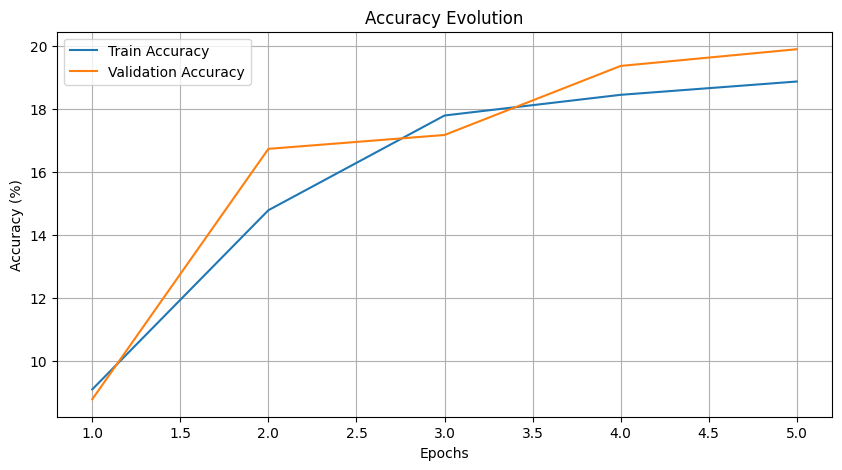

In [8]:
# Representamos la evolución del accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, n_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Evolution')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Imprimir pesos
pesos = model.fc3.weight
print(f"Pesos: {pesos.shape}")
print(pesos[0])
gradiente = pesos.grad
print(f"Gradiente: {gradiente.shape}")
print(gradiente[0])

Pesos: torch.Size([10, 84])
tensor([0.2861, 0.1566, 0.1835, 0.3072, 0.2131, 0.4490, 0.2231, 0.2356, 0.2522,
        0.4543, 0.2926, 0.1796, 0.2022, 0.3830, 0.2653, 0.4557, 0.4898, 0.3405,
        0.5614, 0.2131, 0.2051, 0.4099, 0.4692, 0.4457, 0.2487, 0.1714, 0.1983,
        0.2246, 0.2640, 0.4164, 0.2323, 0.5415, 0.5560, 0.2846, 0.2045, 0.2694,
        0.4746, 0.1722, 0.2381, 0.3376, 0.2684, 0.3095, 0.2501, 0.2772, 0.2235,
        0.3025, 0.2576, 0.1644, 0.5051, 0.3688, 0.2345, 0.2408, 0.2045, 0.2078,
        0.2762, 0.1601, 0.4743, 0.2916, 0.5002, 0.5497, 0.4513, 0.2368, 0.2387,
        0.2631, 0.3420, 0.2588, 0.4279, 0.3142, 0.2624, 0.1964, 0.4648, 0.2486,
        0.2880, 0.2006, 0.2746, 0.1952, 0.2574, 0.2893, 0.3336, 0.5376, 0.2575,
        0.2085, 0.2368, 0.3002], grad_fn=<SelectBackward0>)
Gradiente: torch.Size([10, 84])
tensor([ 0.0008, -0.0419, -0.0332, -0.0702, -0.0471, -0.0815, -0.0528, -0.0570,
        -0.0518, -0.0944, -0.0369, -0.0253, -0.0482, -0.1192, -0.0362, -0.0923,


## Guardar y cargar un modelo entrenado

In [10]:
def save_model(model, optimizer, path='./model.pth'):
    state = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(state, path)
    print(f"Model saved to {path}")

def load_model(model, optimizer, path='./model.pth'):
    checkpoint = torch.load(path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model loaded from {path}, starting from epoch {epoch}")